In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests
# from pylab import rcParams
# from pmdarima.arima import auto_arima
import os
import matplotlib.pyplot as plt
import pyflux as pf
# import statsmodels.api as sm
# # import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore")

In [2]:
# Load our dataset which has should have format [date, tweet, sentiment scores in a column labeled compound]
# Fine to have more columns, but we need at least these three

# In this case our compound column is composed of sentiment scores from VADER
# In our testing this method performed better than GCP NLP, IBM-Watson NLU, and TextBlob  
# https://github.com/cjhutto/vaderSentiment
non_neutral_df = pd.read_csv("data/Total_Processed_TwitterData_oct18-oct19.csv")

# When ready for collab:
non_neutral_df = pd.read_csv("https://peyck.es/BDA/Total_Processed_TwitterData_oct18-oct19.csv")

In [5]:
# Across all sentiment analysis tools, there are a large number of "neutral" tweets
# These will compromise performance later so we will filter out all sentiment scores == 0

# Formatting: we want to end with an index of dates and all tweets with nonzero sentiment
non_neutral_df = non_neutral_df.drop(columns={'Unnamed: 0'}, axis=1)
non_neutral_df = non_neutral_df[non_neutral_df['compound']!=0]
non_neutral_df['date'] = pd.to_datetime(non_neutral_df.date)
non_neutral_df.head()

,date,text,polarity_value,neg,pos,neu,compound
0,2019-04-01 00:00:00,STEAL: Over 50% OFF + free shipping on the Nik...,"{'neg': 0.169, 'neu': 0.689, 'pos': 0.142, 'co...",0.169,0.142,0.689,-0.1613
1,2019-04-01 00:00:00,Check out #Nike Dry Fit Shorts Women's Tempo N...,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0.000,0.206,0.794,0.6369
4,2019-04-01 00:00:00,@MichaelAvenatti He aint dumb he is not showin...,"{'neg': 0.166, 'neu': 0.758, 'pos': 0.076, 'co...",0.166,0.076,0.758,-0.2955
6,2019-04-01 00:00:00,"NIKE AIR VAPORMAX FLYKNIT 3 ""LIMITED EDITION f...","{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'comp...",0.208,0.000,0.792,-0.3885
10,2019-04-01 00:01:00,Perfect time for Nike to amp up their @Kaepern...,"{'neg': 0.0, 'neu': 0.73, 'pos': 0.27, 'compou...",0.000,0.270,0.730,0.5719


In [7]:
# We will only need date and compound sentiment scores for this model
# Make a dataframe with only date and compound sentiment scores
data_scoresOnly = []
data_scoresOnly = non_neutral_df[['date','compound']].copy()
data_scoresOnly['date'] = pd.to_datetime(data_scoresOnly.date)
data_scoresOnly.set_index('date')
print()

In [8]:
# There is no live stock data on weekends, so let's only look at weekdays
# Make a new dataframe of only weekdays
data_weekdayScores = data_scoresOnly.copy()
data_weekdayScores['weekday'] = data_weekdayScores['date'].apply(lambda x: x.weekday())

# Because we are looking at a long range forecast, we are going to average sentiment over full days
data_weekdayScores = data_weekdayScores.resample('D', on='date').mean()
data_weekdayScores = data_weekdayScores[data_weekdayScores['weekday'] < 5]
data_weekdayScores = data_weekdayScores[[ 'compound']]

In [9]:
# At this point we have a dataframe with sentiment scores for all weekdays from the past year
# Get Financial Data for modeling so we can begin building our models
start=datetime(2018,10,1)
end=datetime(2019,10,30)
df = web.DataReader(['NKE'], 'yahoo', start, end)
df['datetime']=df.index
df['datetime'] = pd.to_datetime(df['datetime'])
finance_df=df.set_index("datetime").copy()
finance_df['date']=df['datetime']
# finance_df.info()

In [11]:
# For now, let's look only at Adjusted Close
# Make a new data frame with Adjusted Close, and our compound sentiment scores
data_weekdayScores['AdjClose'] = finance_df.iloc[:,0]
data_weekdayScores['AdjClose'] = data_weekdayScores['AdjClose'].fillna(method='bfill')
model_df = data_weekdayScores.copy()
model_df = model_df.fillna(method='ffill')
# model_df.head(10)

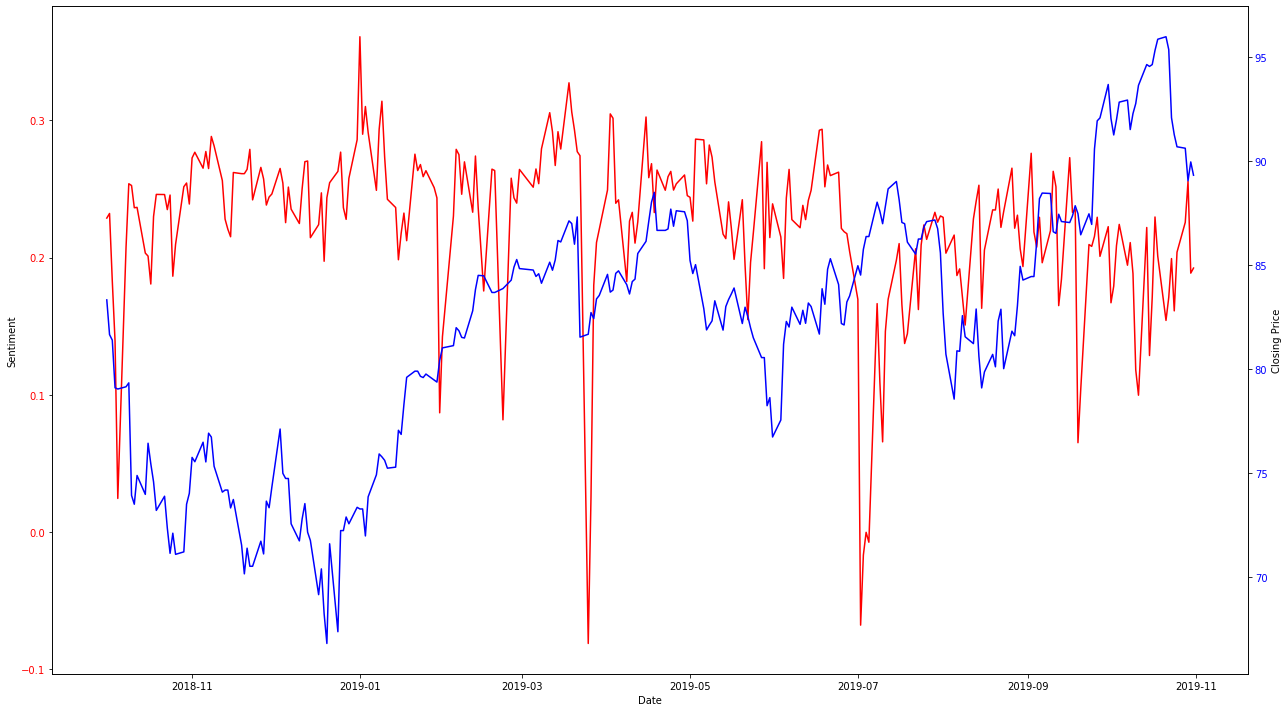

In [13]:
#Plot to see if there are any immediately visible relationships 
fig, ax1 = plt.subplots(figsize=(18,10))
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax1.plot(model_df.index, model_df['compound'], color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Closing Price')
ax2.plot(model_df.index, model_df['AdjClose'], color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
fig.tight_layout()
plt.show()

In [14]:
# Tough to say at first glance: The largest negative spike in sentimennt occurs the same day
# as a significant price drop but the second largest negative spike happens a date range with
# a significant price increase

In [19]:
# Causality Testing from statsmodels
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html


# A low P value suggests that your sample provides enough evidence that you can reject the null hypothesis 
# for the entire population.

# The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT 
# Granger cause the time series in the first column, x1. 

causality_array = model_df.to_numpy().copy()

#Swapping the columns because Granger analysis is the measure of whether time series in col 2 causes col 1
causality_array[:,[0, 1]] = causality_array[:,[1, 0]]
causality = grangercausalitytests(causality_array, maxlag=50)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9034  , p=0.1688  , df_denom=274, df_num=1
ssr based chi2 test:   chi2=1.9243  , p=0.1654  , df=1
likelihood ratio test: chi2=1.9176  , p=0.1661  , df=1
parameter F test:         F=1.9034  , p=0.1688  , df_denom=274, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6595  , p=0.1922  , df_denom=271, df_num=2
ssr based chi2 test:   chi2=3.3802  , p=0.1845  , df=2
likelihood ratio test: chi2=3.3596  , p=0.1864  , df=2
parameter F test:         F=1.6595  , p=0.1922  , df_denom=271, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8669  , p=0.1355  , df_denom=268, df_num=3
ssr based chi2 test:   chi2=5.7469  , p=0.1246  , df=3
likelihood ratio test: chi2=5.6876  , p=0.1278  , df=3
parameter F test:         F=1.8669  , p=0.1355  , df_denom=268, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1640  , p=0.0734  

ssr based F test:         F=1.3601  , p=0.1009  , df_denom=169, df_num=36
ssr based chi2 test:   chi2=70.1145 , p=0.0006  , df=36
likelihood ratio test: chi2=61.5726 , p=0.0050  , df=36
parameter F test:         F=1.3601  , p=0.1009  , df_denom=169, df_num=36

Granger Causality
number of lags (no zero) 37
ssr based F test:         F=1.3487  , p=0.1055  , df_denom=166, df_num=37
ssr based chi2 test:   chi2=72.4460 , p=0.0004  , df=37
likelihood ratio test: chi2=63.3421 , p=0.0045  , df=37
parameter F test:         F=1.3487  , p=0.1055  , df_denom=166, df_num=37

Granger Causality
number of lags (no zero) 38
ssr based F test:         F=1.3442  , p=0.1065  , df_denom=163, df_num=38
ssr based chi2 test:   chi2=75.2119 , p=0.0003  , df=38
likelihood ratio test: chi2=65.4255 , p=0.0037  , df=38
parameter F test:         F=1.3442  , p=0.1065  , df_denom=163, df_num=38

Granger Causality
number of lags (no zero) 39
ssr based F test:         F=1.3564  , p=0.0983  , df_denom=160, df_num=39
ssr b

In [21]:
# Start Modeling
# Our best performing model is ARIMAX 
# https://github.com/RJT1990/pyflux/blob/master/pyflux/arma/arimax.py
# Autoregressive Integrated Moving Average Exogenous Variable Models
# In this case our exogendous variable is sentiment

# Create a train test split for our model
# The training will occur on all tweets from Oct 2018- August 14th 2019
train_ARIMAX = model_df[:int(0.8*(len(model_df)))].copy()
test_ARIMAX = model_df[int(0.8*(len(model_df))):].copy()

model_arimax = pf.ARIMAX(data=train_ARIMAX,formula='AdjClose~1+compound',ar=50, ma=5, integ=0,family=pf.Normal())
model_arimax_fit = model_arimax.fit("MLE")

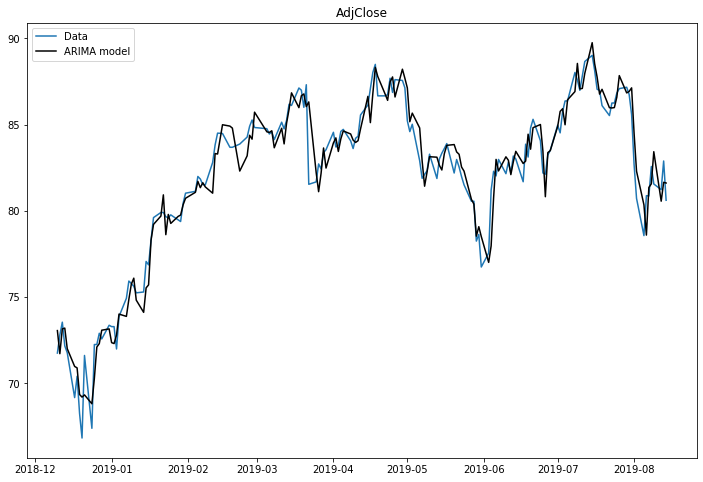

In [112]:
#Let's take a quick look at our model with training data
model_arimax.plot_fit(figsize=(12,8))

In [158]:
x = model_arimax_fit
ind = x.z.z_indices
est = x.z.z_list[ind['AR(1)']['start']].value
est
# model_testing_df = pd.DataFrame(model_arimax_fit.results.data)
# model_testing_df.head()

0.5500115582330203

In [159]:
x.summary()

Normal ARIMAX(50,0,5)                                                                                     
======================================================= ==================================================
Dependent Variable: AdjClose                            Method: MLE                                       
Start Date: 2018-12-10 00:00:00                         Log Likelihood: -246.9054                         
End Date: 2019-08-14 00:00:00                           AIC: 609.8108                                     
Number of observations: 172                             BIC: 792.3654                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.55       0.2263     2.4305   0.0151   (0.1065 | 0.9936)        
AR(2)                                

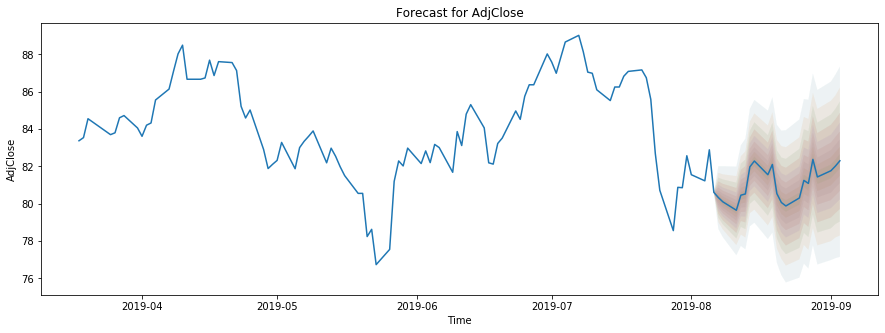

In [24]:
# Now let's predict our test test values
# Reminder: At this point our model has not seen any data past August 14th

# Start with a quick plot of the prediction with prediction intervals
# Darker values mean a higher prediction
model_arimax.plot_predict(h=20, oos_data=test_ARIMAX,past_values=100, figsize=(15,5), intervals=True)



In [26]:
# Seems realistic, but let's take a closer look
# Get our array of values so we can plot with the real values
prediction = model_arimax.predict(h=56, oos_data=train_ARIMAX,intervals=True)

In [27]:
#Take a subset of our real data so we can plot against our prediction over the same range
true_data = model_df.loc[prediction.index[0]:prediction.index[-1]].copy()

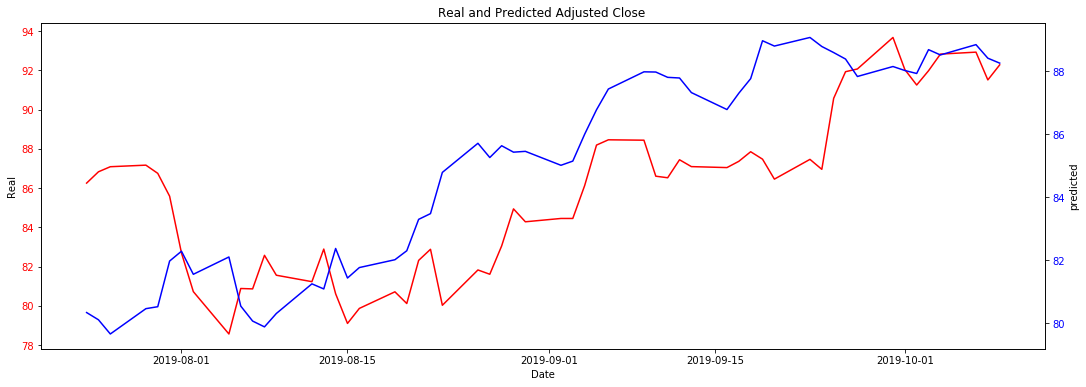

In [113]:
# Now let's plot our predictions on test data vs real data over the date range to get a better idea of accuracy
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Real')
ax1.plot(true_data.index, true_data.iloc[0:56,1], color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('predicted')
ax2.plot(prediction.index, prediction.iloc[0:56,0], color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
plt.title("Real and Predicted Adjusted Close ")
plt.show()

In [29]:
# Although there are some differences in the true price, it is easy to see that our model could be used as
# a useful tool when deciding whether to buy or sell.

In [30]:
# But how much of the model's success is due to sentiment?
# Let's predict using only historical stock data 

In [136]:
# Lets keep all parameters the same but leave out sentiment 
# Duplicate our train test split for our stock only model
train_ARIMA = model_df[:int(0.8*(len(model_df)))].copy()
test_ARIMA = model_df[int(0.8*(len(model_df))):].copy()
del train_ARIMA['compound']
del test_ARIMA['compound']





model_arima = pf.ARIMA(data=train_ARIMA,ar=50, ma=5, integ=0,family=pf.Normal())
model_arima_fit = model_arima.fit("MLE")
# model_arimax_fit.summary()


# Get our array of Predicted values so we can plot with the real values
prediction_ARIMA = model_arima.predict(h=56,intervals=True)
# Make a copy of real financial data from the predicted period
true_data_ARIMA = model_df.loc[prediction.index[0]:prediction_ARIMA.index[-1]].copy()



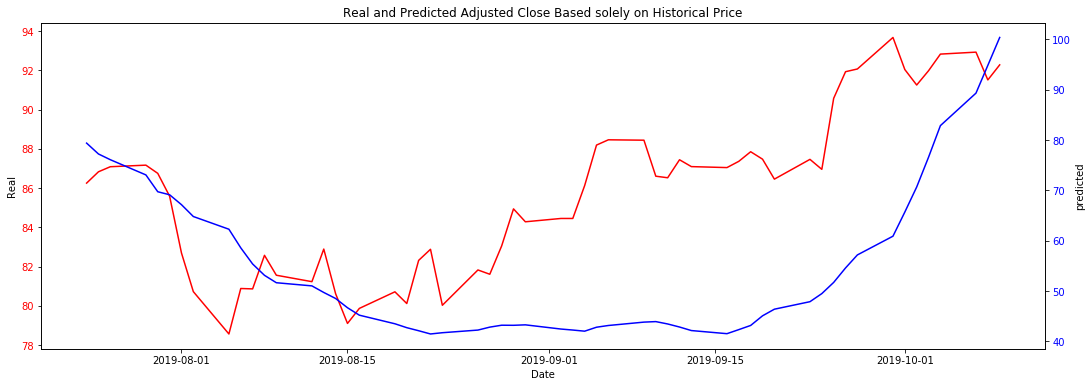

In [137]:
# Now let's plot our predictions vs real data over the date range to get a better idea
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Real')
ax1.plot(true_data_ARIMA.index, true_data_ARIMA.iloc[0:56,1], color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('predicted')
ax2.plot(prediction_ARIMA.index, prediction_ARIMA.iloc[0:56,0], color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
plt.title("Real and Predicted Adjusted Close Based solely on Historical Price")
plt.show()

In [131]:
# Was our prediction on October data just a fluke?
# Today is December 1st 2019, so we can predict the month of November
# No tweets have been gathered for the month of November, so let's see what happens when we 
# model with a full year of sentiment

In [39]:
# Keeping all the same parameters as our first prediction
train_ARIMAX_FullYear = model_df.copy()

model_arimax_FullYear = pf.ARIMAX(data=train_ARIMAX_FullYear,formula='AdjClose~1+compound',ar=50, ma=5, integ=0,family=pf.Normal())
model_arimax_FullYear_fit = model_arimax_FullYear.fit("MLE")

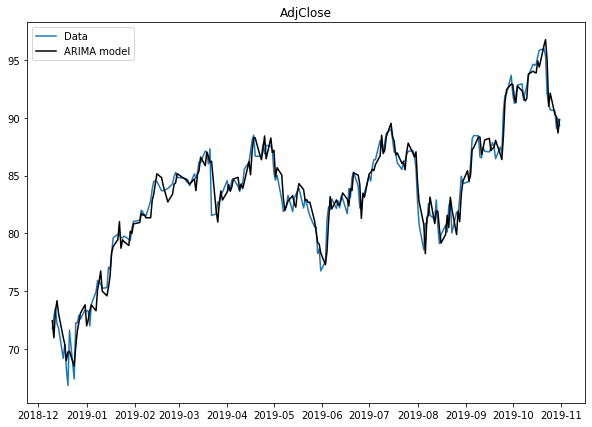

In [41]:
model_arimax_FullYear.plot_fit()

In [63]:
# We want to test over the month of november so let's create an empty dataframe with weekday indicies
test_ARIMAX_FullYear = pd.DatetimeIndex(start ='2019-11-01', end='2019-11-30', freq='B')
df = pd.DataFrame(test_ARIMAX_FullYear,columns={'Date'})
df = df.set_index('Date')
test_ARIMAX_FullYear = df.copy()

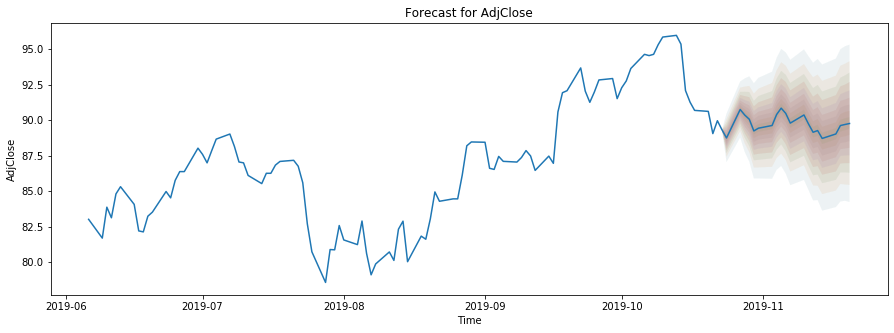

In [65]:
model_arimax_FullYear.plot_predict(h=20, oos_data=train_ARIMAX_FullYear,past_values=100, figsize=(15,5), intervals=True)

In [74]:
# At this point we have a dataframe with sentiment scores for all weekdays from the past year
# Get Financial Data for modeling so we can begin building our models
start=datetime(2019,11,1)
end=datetime(2019,12,26)
df = web.DataReader(['NKE'], 'yahoo', start, end)
df['datetime']=df.index
df['datetime'] = pd.to_datetime(df['datetime'])
finance_df=df.set_index("datetime").copy()
finance_df['date']=df['datetime']
# finance_df.info()

In [67]:
# Get our array of values so we can plot with the real values
prediction_Nov = model_arimax_FullYear.predict(h=56, oos_data=train_ARIMAX_FullYear,intervals=True)

In [92]:
# prediction_Nov is a prediction through December 26th, but we can only compare through Dec12th
# We can combine values to one dataframe so we can easily update when future stock data is available

total_df = finance_df['Adj Close'].copy()
total_df = total_df.join(prediction_Nov, how='left')
# total_df.head(50)

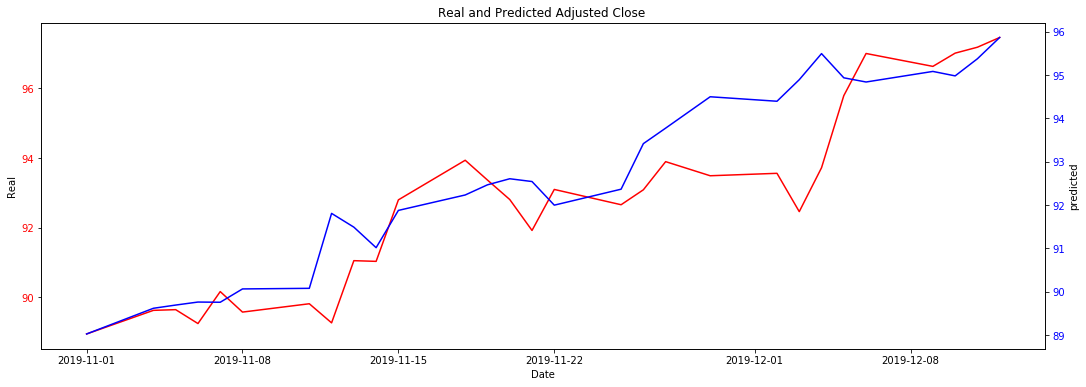

In [91]:
# Now let's plot our predictions on test data vs real data over the date range to get a better idea of accuracy
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Real')
#Real adjusted close price 
ax1.plot(total_df.index, total_df.iloc[:,0], color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('predicted')
ax2.plot(total_df.index, total_df.iloc[:,1], color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
plt.title("Real and Predicted Adjusted Close ")
plt.show()

In [140]:
total_df.to_csv('../data/ToPlot/P3/All.csv')




In [143]:
# So Should you Buy or Sell?
last_prediction = prediction_Nov[-10:].copy()
last_prediction.to_csv('../data/ToPlot/P4/Final.csv')



In [99]:
# Wait until Monday! (But don't buy too much)

In [101]:
causality[50].

({'ssr_ftest': (1.6464253436076988, 0.013610563587524877, 127.0, 50),
  'ssr_chi2test': (147.78936155218716, 1.344539853842532e-11, 50),
  'lrtest': (113.92775793145393, 6.78403695657841e-07, 50),
  'params_ftest': (1.6464253436076839, 0.013610563587526246, 127.0, 50.0)},
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.]])])

In [106]:
# Testing saved Data
model_arimax_fit.data

array([71.7501297 , 72.7990036 , 73.54114532, 72.16571045, 71.76990509,
       69.16746521, 70.40436554, 68.24721527, 66.82230377, 71.61158752,
       67.38632965, 72.24488068, 72.24488068, 72.89795685, 72.57141113,
       73.36302948, 73.28386688, 73.28386688, 71.98760986, 73.86769867,
       74.92648315, 75.92589569, 75.78735352, 75.61914062, 75.24312592,
       75.29259491, 77.06384277, 76.86594391, 78.3007431 , 79.60690308,
       79.90376282, 79.90376282, 79.6563797 , 79.59701538, 79.76522827,
       79.47827911, 79.37931824, 80.4282074 , 81.02191925, 81.13077545,
       81.99165344, 81.84322357, 81.52657318, 81.49688721, 82.80305481,
       83.82226562, 84.5050354 , 84.48523712, 83.68373108, 83.68373108,
       83.87173462, 84.27745056, 84.90084076, 85.26696777, 84.83157349,
       84.76213837, 84.45458984, 84.58356476, 84.12722015, 85.13912201,
       84.7522049 , 85.24824524, 86.18079376, 86.11134338, 87.12324524,
       86.99427795, 86.00222015, 87.31175232, 81.53791809, 81.67

In [108]:
model_arimax.data

array([83.3275528 , 81.66020966, 81.39383698, 79.10494995, 79.04575348,
       79.15428162, 79.34172821, 73.93520355, 73.51097107, 74.89219666,
       73.98452759, 76.44114685, 75.4545517 , 74.58634949, 73.21498871,
       73.89573669, 72.36651611, 71.15301514, 72.11986542, 71.10368347,
       71.22207642, 73.51097107, 74.03385925, 75.76039124, 75.5532074 ,
       76.49047089, 75.54335022, 76.92457581, 76.73711395, 75.33616638,
       74.0930481 , 74.19171906, 74.19171906, 73.33337402, 73.73788452,
       71.54763794, 70.16641998, 71.39966583, 70.53146362, 70.53146362,
       71.73509979, 71.12340546, 73.65895844, 73.34323883, 74.33277893,
       77.12320709, 74.9957428 , 74.74836731, 74.74836731, 72.57141113,
       71.7501297 , 72.7990036 , 73.54114532, 72.16571045, 71.76990509,
       69.16746521, 70.40436554, 68.24721527, 66.82230377, 71.61158752,
       67.38632965, 72.24488068, 72.24488068, 72.89795685, 72.57141113,
       73.36302948, 73.28386688, 73.28386688, 71.98760986, 73.86

In [110]:
model_arimax_fit.data

array([71.7501297 , 72.7990036 , 73.54114532, 72.16571045, 71.76990509,
       69.16746521, 70.40436554, 68.24721527, 66.82230377, 71.61158752,
       67.38632965, 72.24488068, 72.24488068, 72.89795685, 72.57141113,
       73.36302948, 73.28386688, 73.28386688, 71.98760986, 73.86769867,
       74.92648315, 75.92589569, 75.78735352, 75.61914062, 75.24312592,
       75.29259491, 77.06384277, 76.86594391, 78.3007431 , 79.60690308,
       79.90376282, 79.90376282, 79.6563797 , 79.59701538, 79.76522827,
       79.47827911, 79.37931824, 80.4282074 , 81.02191925, 81.13077545,
       81.99165344, 81.84322357, 81.52657318, 81.49688721, 82.80305481,
       83.82226562, 84.5050354 , 84.48523712, 83.68373108, 83.68373108,
       83.87173462, 84.27745056, 84.90084076, 85.26696777, 84.83157349,
       84.76213837, 84.45458984, 84.58356476, 84.12722015, 85.13912201,
       84.7522049 , 85.24824524, 86.18079376, 86.11134338, 87.12324524,
       86.99427795, 86.00222015, 87.31175232, 81.53791809, 81.67